# Approach

Another way to explore this data is to use supervised learning to build a classifier. Now, there are two uses of a classifier, and one tends to be emphasized much more than the other.

    1. A classifier can be used to generate an automatic procedure for labeling points. This is useful if you want a method that automatically tells cars whether the object in front of them is a car or a pedestrian.
    2. To identify features that are good predictors of labeled points.
    
I suppose that a central part of my philosophy is that point (2) is much more important in biological research than point (1). This has some implications down-stream (for example, we are *slightly* less worried about overfitting if we can test selected features via an orthogonal experimental approach).

Here, we want to build a classifier that uses gene expression levels to predict a binary outcome, `luminal A` or `luminal B`. However, we would like our machine to identify a **small** number of features that can accurately predict the outcome. 

Typically, binary outcome prediction can be performed using logistic regression. However, in general, if we input $n$ features into a logistic regression algorithm, all $n$ features will have non-zero prediction coefficients: all genes will participate in the classification problem. While this could be useful in principle, in reality we often want to interpret the biomarkers, so we would like an algorithm that *discards* most gene expression levels in favor of a select few (there are additional problems with using 20,000 covariates, namely, overfitting).

How can we modify logistic regression algorithms to do this? Well, an easy way is to exchange the commonly used $l_2$ norm for an $l_1$ norm. That is, instead of minimizing the sum of squares of the residuals, we can minimize the absolute value of the residuals. This has profound consequences, because the $l_1$ norm naturally drives coefficients that would simply be small under $l_2$ penalties towards extinction. 

Note: Some people would use LASSO to address this problem. LASSO is a modified linear regression procedure similar to least-squares. Whereas least-squares uses an $l_2$ norm, LASSO performs the linear regression under an $l_1$ constraint. However, since our problem is categorical, I find $l_1$-norm regularized logistic regression a more suitable solution.

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import umap

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.linear_model import LogisticRegression

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

Load data

In [3]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

Subset data into training sets:

In [4]:
train_idx = np.random.choice(normed.T.index.values,
                             size=np.int(np.floor(len(normed.columns) / 3 * 2)),
                             replace=False).tolist()
test_idx = [n for n in normed.T.index if n not in train_idx]

train_exp = normed.T[normed.T.index.isin(train_idx)]
train_labels = meta[meta.ID.isin(train_idx)].cancer 

test_exp = normed.T[normed.T.index.isin(test_idx)]
test_labels = meta[meta.ID.isin(test_idx)].cancer

# Finding a suitable sparsity constraint

For this exercise, I use the `sklearn` implementation of logistic regression. In this implementation, we can, and do, select the $l_1$ norm to naturally sparsify values. Next, we can also modulate the regularization penalty -- a number that will make the effect of the $l_1$ norm larger or smaller. This parameter ought to be chosen carefully. To do this, I tile over possible values of this parameter, which can take values between (0, 1], and repeatedly train the machine and retrieve its total score. Next, we will define a loss function to identify an optimal sparsity value. Our loss function will be:

$$
L = C^2 - S_{logit},
$$

where $C$ is the sparsity constraint, and $S_{logit}$ is the fraction of all labels in the training set that were correctly assigned by the machine.

In [5]:
c = np.linspace(0.01, .99, 20)

models = {}
for ci in c:
    model = LogisticRegression(
        penalty='l1',  # use l1 norm for sparsity of values
        solver='saga',  # i like saga
        C=ci,  # C sets sparsity; higher C more sparsity
        max_iter=5000)  # number of iterations to run
    model.fit(train_exp, train_labels)
    models[ci] = model

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/

Loss is minimized at 0.165
Out of the box performance is: 0.86
Fraction of Luminal_A in test set: 0.67


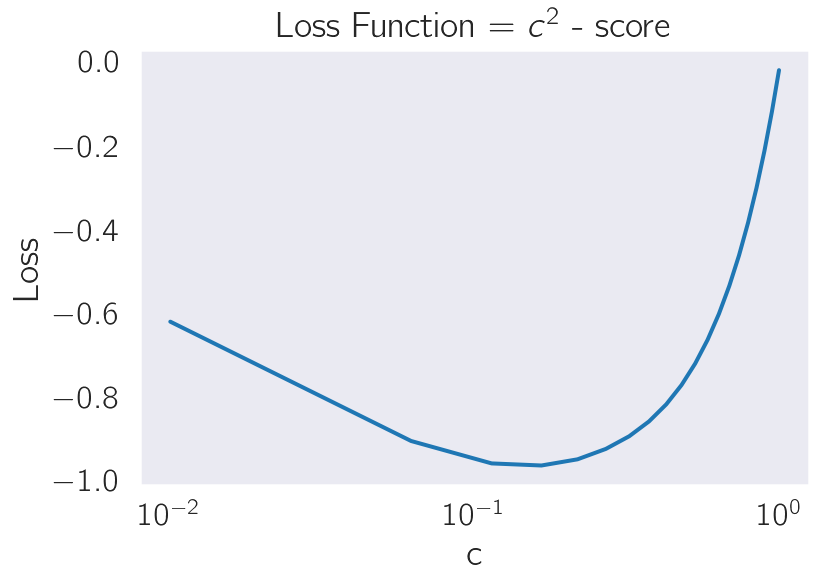

In [6]:
# define loss function:
loss = lambda x: x **2 - models[x].score(train_exp, train_labels)

# calculate loss function
l = np.array([loss(ci) for ci in c])
# find minimizing c value for loss:
cval = c[np.argmin(l)]

# plot:
plt.plot(c, l)
plt.title('Loss Function = $c^2$ - score')
plt.xlabel('c')
plt.ylabel('Loss')
plt.xscale('log')

print('Loss is minimized at {0:.3g}'.format(c[np.argmin(l)]))
print('Out of the box performance is: {0:.2g}'.format(models[cval].score(test_exp, test_labels)))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test_labels == 'Luminal_A').sum() / len(test_labels)))

It looks like our loss is minimized at $C=0.165$. At this value, the out-of-the-box performance is 0.86 -- almost 20 percentile points greater than the accuracy we would achieve by simply naming everything `Luminal A`. This looks very promising. Next, let's view the distribution of model coefficients for all gene expression levels. Remember: We expect the great majority to be centered around zero, and the non-zero coefficients probably ought to be symmetrically distributed around 0.

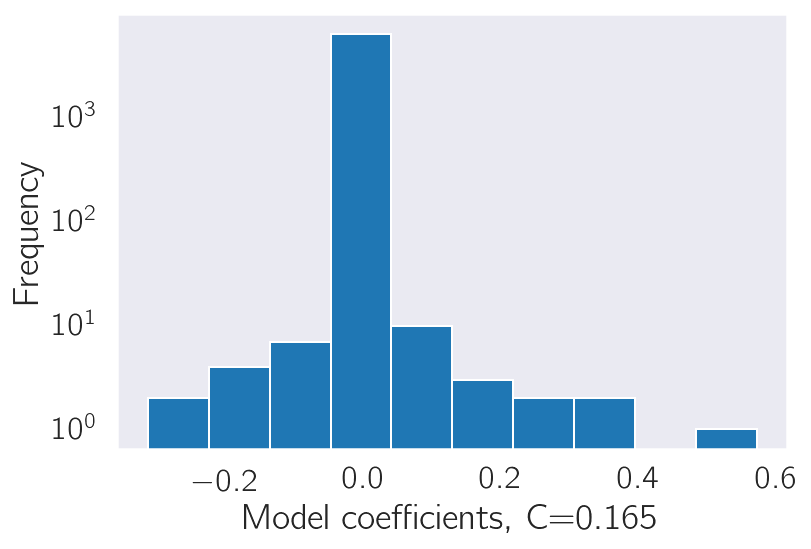

In [8]:
plt.hist(models[cval].coef_[0])
plt.yscale('log')
plt.xlabel('Model coefficients, C={0:.3g}'.format(cval))
_ = plt.ylabel('Frequency')

# What genes are selected as features?

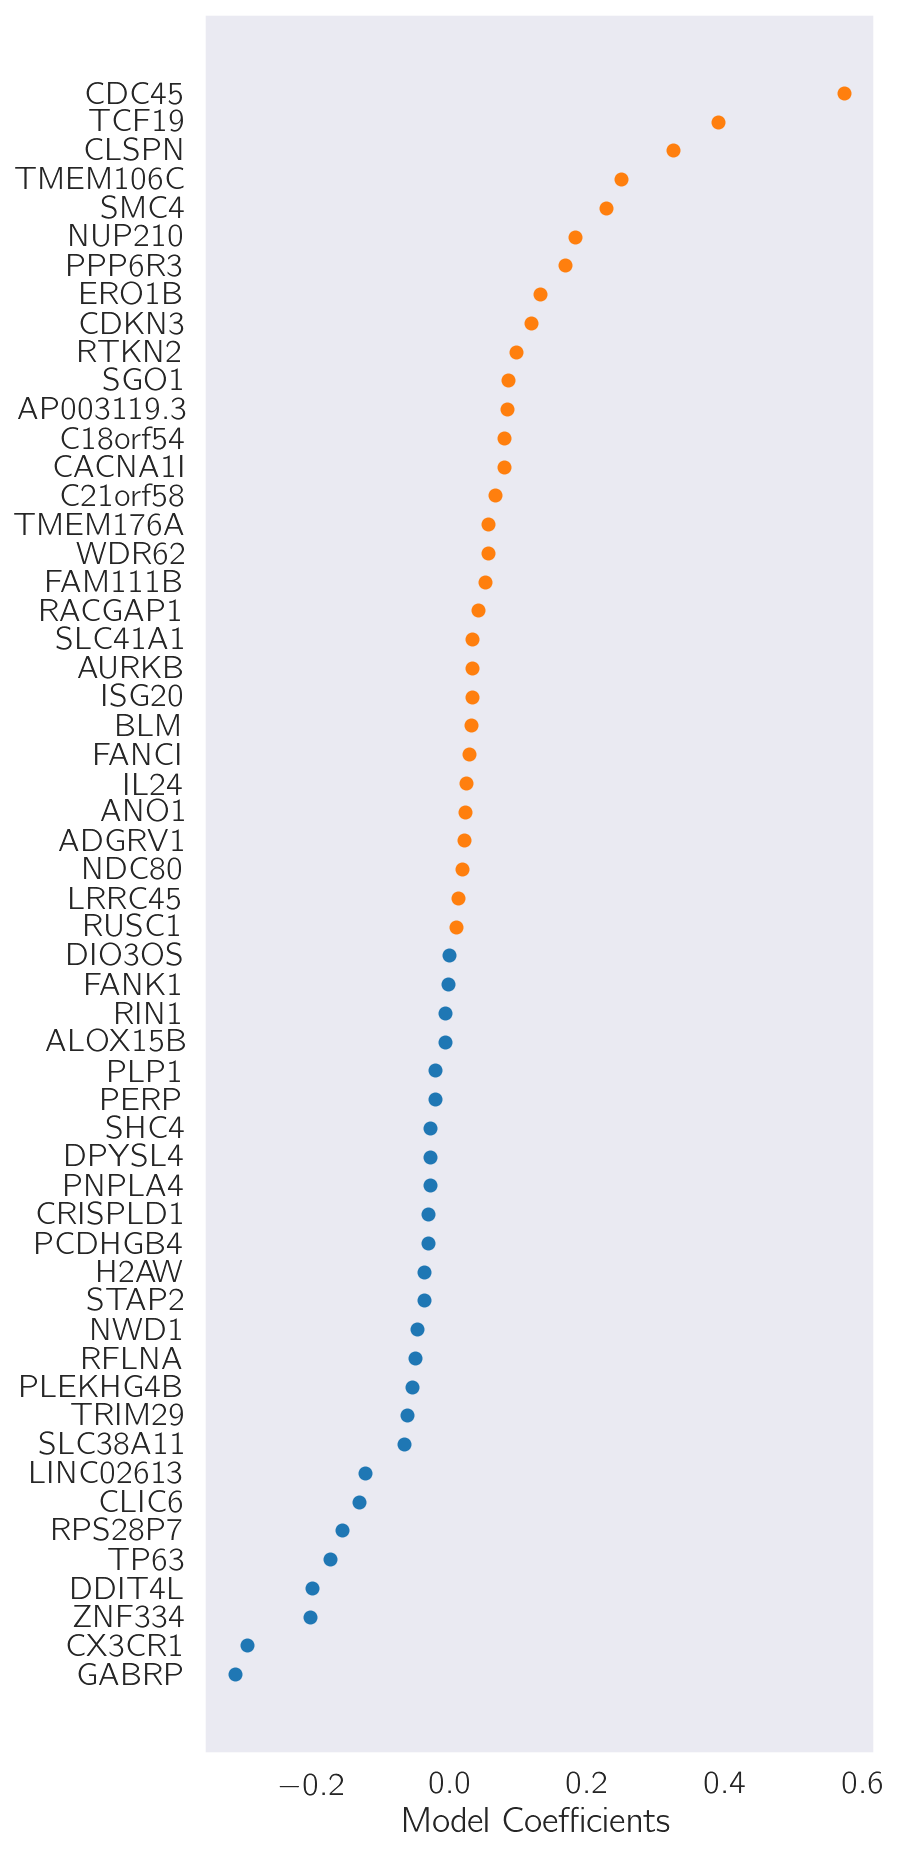

In [18]:
markers = df.index[np.where(models[cval].coef_[0] != 0)[0]].values
ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)].copy()
ens_mark.ensembl_gene_id = ens_mark.ensembl_gene_id.astype('category')
ens_mark.ensembl_gene_id.cat.set_categories(markers, inplace=True)
ens_mark.sort_values("ensembl_gene_id", inplace=True)

x = models[cval].coef_[0][models[cval].coef_[0] != 0]
sort = np.argsort(x)

fig, ax = plt.subplots(figsize=(6, 16))

for i in ['neg', 'pos']:
    if i == 'pos':
        plt.plot(x[sort][x[sort] > 0],
                 ens_mark.external_gene_name.values[sort][x[sort] > 0],
                 'o')
    else:
        plt.plot(x[sort][x[sort] < 0],
                 ens_mark.external_gene_name.values[sort][x[sort] < 0],
                 'o')
_ = plt.xlabel('Model Coefficients')

## Is there enrichment of ontological terms? 

Sometimes, we can perform `pathway enrichment` analyses on the data. Here, I perform the test three ways: On all the coefficients simultaneously, and then on the positive and negative coefficients separately. Intuitively, we might expect that splitting should yield better results, since the two cancer types may be driven by different molecular etiologies.

In [10]:
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0008608,attachment of spindle microtubules to kinetochore,0.005312,True,"""The process in which spindle microtubules bec...",35,49,4,18092,0.081633,0.114286,query_1,"[GO:0022402, GO:0098813]"
1,REAC,REAC:R-HSA-69620,Cell Cycle Checkpoints,0.025382,True,Cell Cycle Checkpoints,270,29,6,10531,0.206897,0.022222,query_1,[REAC:R-HSA-1640170]


### Negative coefficient genes
Let's see what enrichment results from the negative enrichment:

In [11]:
markers = df.index[np.where(models[cval].coef_[0] < 0)[0]].values
ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)]
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,REAC,REAC:R-HSA-6803205,TP53 regulates transcription of several additi...,0.023971,True,TP53 regulates transcription of several additi...,14,11,2,10531,0.181818,0.142857,query_1,[REAC:R-HSA-5633008]
1,GO:MF,GO:0031005,filamin binding,0.034573,True,"""Interacting selectively and non-covalently wi...",13,23,2,18694,0.086957,0.153846,query_1,[GO:0008092]
2,HP,HP:0000970,Anhidrosis,0.049975,True,Inability to sweat.,24,3,2,4461,0.666667,0.083333,query_1,[HP:0025276]


Not a lot. Nothing interpretable, at least!

### What about genes with positive coefficients?

In [12]:
markers = df.index[np.where(models[cval].coef_[0] > 0)[0]].values
ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)]
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0008608,attachment of spindle microtubules to kinetochore,0.000369,True,"""The process in which spindle microtubules bec...",35,27,4,18092,0.148148,0.114286,query_1,"[GO:0022402, GO:0098813]"
1,GO:BP,GO:1903047,mitotic cell cycle process,0.000787,True,"""A process that is part of the mitotic cell cy...",921,27,10,18092,0.370370,0.010858,query_1,"[GO:0000278, GO:0022402]"
2,REAC,REAC:R-HSA-1640170,Cell Cycle,0.001033,True,Cell Cycle,624,18,8,10531,0.444444,0.012821,query_1,[REAC:0000000]
3,REAC,REAC:R-HSA-69620,Cell Cycle Checkpoints,0.001063,True,Cell Cycle Checkpoints,270,18,6,10531,0.333333,0.022222,query_1,[REAC:R-HSA-1640170]
4,GO:BP,GO:0000278,mitotic cell cycle,0.003083,True,"""Progression through the phases of the mitotic...",1069,27,10,18092,0.370370,0.009355,query_1,[GO:0007049]
5,GO:BP,GO:0000070,mitotic sister chromatid segregation,0.006692,True,"""The cell cycle process in which replicated ho...",161,27,5,18092,0.185185,0.031056,query_1,"[GO:0000819, GO:0140014, GO:1903047]"
6,GO:CC,GO:0098687,chromosomal region,0.008383,True,"""Any subdivision of a chromosome along its len...",262,28,5,18963,0.178571,0.019084,query_1,"[GO:0005694, GO:0110165]"
7,TF,TF:M00431_1,Factor: E2F-1; motif: TTTSGCGS; match class: 1,0.013170,True,Factor: E2F-1; motif: TTTSGCGS; match class: 1,2271,29,13,19728,0.448276,0.005724,query_1,[TF:M00431]
8,GO:BP,GO:0000819,sister chromatid segregation,0.014636,True,"""The cell cycle process in which sister chroma...",189,27,5,18092,0.185185,0.026455,query_1,"[GO:0051276, GO:0098813]"
9,WP,WP:WP4016,DNA IR-damage and cellular response via ATR,0.017311,True,DNA IR-damage and cellular response via ATR,80,11,3,7399,0.272727,0.037500,query_1,[WP:000000]


It looks like the positive coefficients are enriched for genes that function in cell division and replication! Oh, that's a neat result!

In [13]:
ens_mark

,ensembl_gene_id,gene_biotype,external_gene_name,description
9087,ENSG00000160298,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...
9574,ENSG00000080986,protein_coding,NDC80,NDC80 kinetochore complex component [Source:HG...
9655,ENSG00000093009,protein_coding,CDC45,cell division cycle 45 [Source:HGNC Symbol;Acc...
11688,ENSG00000166845,protein_coding,C18orf54,chromosome 18 open reading frame 54 [Source:HG...
12288,ENSG00000100346,protein_coding,CACNA1I,calcium voltage-gated channel subunit alpha1 I...
21251,ENSG00000100526,protein_coding,CDKN3,cyclin dependent kinase inhibitor 3 [Source:HG...
24456,ENSG00000182010,protein_coding,RTKN2,rhotekin 2 [Source:HGNC Symbol;Acc:HGNC:19364]
25193,ENSG00000137310,protein_coding,TCF19,transcription factor 19 [Source:HGNC Symbol;Ac...
35085,ENSG00000132182,protein_coding,NUP210,nucleoporin 210 [Source:HGNC Symbol;Acc:HGNC:3...
35155,ENSG00000164199,protein_coding,ADGRV1,adhesion G protein-coupled receptor V1 [Source...


# Make sure re-running the algorithm with different random seeds doesn't change the result significantly

It doesn't, but in case you don't believe me, here's the analysis. All runs performed with the same training set and parameter settings, just different random seeds.

In [14]:
# test feature stability:
reps = []
for i in np.arange(1, 20):
    model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=cval,
        max_iter=5000,
        random_state=i)
    model.fit(train_exp, train_labels)
    reps += [model]

In [15]:
def get_features(data, cond=np.where(models[cval].coef_[0] != 0)[0]):
    markers = data.index.values[cond]
    ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)].copy()
    ens_mark.ensembl_gene_id = ens_mark.ensembl_gene_id.astype('category')
    ens_mark.ensembl_gene_id.cat.set_categories(markers, inplace=True)
    ens_mark.sort_values("ensembl_gene_id", inplace=True)
    missing = np.array([0 if m not in ensembl.ensembl_gene_id.values else 1 for m in markers ])
    return ens_mark, missing

genes = []
for r in reps:
    f, miss = get_features(normed, np.where(r.coef_[0] != 0)[0])
    f = f.external_gene_name.values
    genes += f.tolist()

In [22]:
uniq, counts = np.unique(genes, return_counts=True)
print(len(uniq), counts.min(), counts.max())
np.savetxt('../luminalAB/logistic_genes.txt', uniq, delimiter=',', fmt='%s')

56 19 19


The same set of 56 genes shows up each time. That's a bit surprising, at least to me.